# Snow cover MODIS-TERRA
## Snowrunoff - february, 2023
##### Paul Sandoval Quilodrán - https://github.com/SQPaul

#### import packages

In [82]:
import rasterio as rio
import rioxarray as rioxr
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal
import glob
import subprocess
import matplotlib.pyplot as plt
import regionmask
from shapely.geometry import mapping, box
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.patches as mpatches

### Resampling global product (extent, crs, and resolution)
#### RUN IN QGIS!!!
##### * Open 12 files in QGIS, and then edit [x,y] in snow_cover[0:9]

In [ ]:
import glob
import os

snow_cover = glob.glob(r"P:\Projects\Itata\GIS\Snowcover\*.hdf")
snow_cover = snow_cover[0:9]

for i in snow_cover:
    i_path = i.replace(os.sep,'/')
    date = i[41:-22]
    year = i[41:-25]
    month = i[45:-22]
    name_couple = i[2:]
    name_couple2 = i[2:-67]
    long_name = "'HDF4_EOS:EOS_GRID"+':\\"'+str(i_path[:])+name_couple2+'\"'+":MOD_CMG_Snow_5km:Snow_Cover_Monthly_CMG'"
    long_name2 = "HDF4_EOS:EOS_GRID"+':"'+str(i_path[:])+'"'+":MOD_CMG_Snow_5km:Snow_Cover_Monthly_CMG"
    if month == "001":
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"01.tif"
    if month == "032":
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"02.tif"
    if month == "060" or month == "061": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"03.tif"
    if month == "091" or month == "092": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"04.tif"
    if month == "121" or month == "122": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"05.tif"
    if month == "152" or month == "153": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"06.tif"
    if month == "182" or month == "183": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"07.tif"
    if month == "213" or month == "214": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"08.tif"
    if month == "244" or month == "245": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"09.tif"
    if month == "274" or month == "275": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"10.tif"
    if month == "305" or month == "306": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"11.tif"
    if month == "335" or month == "336": 
        out_name = r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\sc_"+year+"12.tif"

    processing.run("gdal:warpreproject", {'INPUT':str(long_name2),
                                          'SOURCE_CRS':None,'TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:32719'),
                                          'RESAMPLING':1,'NODATA':None,'TARGET_RESOLUTION':5000,'OPTIONS':'','DATA_TYPE':0,
                                          'TARGET_EXTENT':'123516.000000000,348516.000000000,5841643.000000000,6006643.000000000 [EPSG:32719]',
                                          'TARGET_EXTENT_CRS':None,'MULTITHREADING':False,'EXTRA':'','OUTPUT':str(out_name)})

### Playing with nodata

In [280]:
snow_cover = glob.glob(r"P:\Projects\Itata\GIS\Snowcover\raw_with_dates\*.tif")

mask_tif = rio.open(r"P:\Projects\Itata\GIS\mask_itata.tif")
mask = mask_tif.read(1)

jan = []
feb = []
mar = []
apr = []
may = []
jun = []
jul = []
aug = []
sep = []
octo = []
nov = []
dec = []

summ = [] #dec, ene, feb  - 12, 01, 02
autu = [] #mar, apr, may  - 03, 04, 05
wint = [] #jun, jul, aug  - 06, 07, 08
spri = [] #sep, oct, nov  - 09, 10, 11

all_mon = [jan,feb,mar,apr,may,jun,jul,aug,sep,octo,nov,dec]
season = [summ,autu,wint,spri]

for i in snow_cover:
    year = i[50:-6]
    month = i[54:-4]
    snow = rio.open(i).read(1).astype(np.float64)
    for x in range(snow.shape[0]):
        for y in range(snow.shape[1]):
            if snow[x,y] > 0 and snow[x,y] <= 100:
                snow[x,y] = snow[x,y]
            else:
                snow[x,y] = 999
    if month == "01":
        jan.append(snow)
        summ.append(snow)
    if month == "02":
        feb.append(snow)
        summ.append(snow)
    if month == "03":
        mar.append(snow)
        autu.append(snow)
    if month == "04":
        apr.append(snow)
        autu.append(snow)
    if month == "05":
        may.append(snow)
        autu.append(snow)
    if month == "06":
        jun.append(snow)
        wint.append(snow)
    if month == "07":
        jul.append(snow)
        wint.append(snow)
    if month == "08":
        aug.append(snow)
        wint.append(snow)
    if month == "09":
        sep.append(snow)
        spri.append(snow)
    if month == "10":
        octo.append(snow)
        spri.append(snow)
    if month == "11":
        nov.append(snow)
        spri.append(snow)
    if month == "12":
        dec.append(snow)
        summ.append(snow)

### Season maps (good)

In [281]:
mask_tif = rio.open(r"P:\Projects\Itata\GIS\mask_itata.tif")
mask = mask_tif.read(1)

## SUMMER

total = spri[0]*0
length = spri[0]*0

for i in summ:
    for x in range(i.shape[0]):
        for y in range(i.shape[1]):
            if i[x,y] != 999:
                total[x,y] = total[x,y]+i[x,y]
                length[x,y] = length[x,y]+1         

snow = total/length
for x in range(snow.shape[0]):
    for y in range(snow.shape[1]):
        if snow[x,y] <= 10:
            snow[x,y] = np.nan
            
name = r"P:\Projects\Itata\GIS\Snowcover\season\sc"+str(1)+".tif"
snow_r = rio.open(str(name),
                  "w",
                  driver = "GTiff",
                  height = mask.shape[0],
                  width = mask.shape[1],
                  count = 1,
                  nodata = np.nan,
                  dtype = np.float32,
                  crs = 32719,
                  transform = mask_tif.transform)
snow_r.write(snow,1)
snow_r.close()

## AUTUMN

total = spri[0]*0
length = spri[0]*0

for i in autu:
    for x in range(i.shape[0]):
        for y in range(i.shape[1]):
            if i[x,y] != 999:
                total[x,y] = total[x,y]+i[x,y]
                length[x,y] = length[x,y]+1         

snow = total/length
for x in range(snow.shape[0]):
    for y in range(snow.shape[1]):
        if snow[x,y] <= 10:
            snow[x,y] = np.nan
            
name = r"P:\Projects\Itata\GIS\Snowcover\season\sc"+str(2)+".tif"
snow_r = rio.open(str(name),
                  "w",
                  driver = "GTiff",
                  height = mask.shape[0],
                  width = mask.shape[1],
                  count = 1,
                  nodata = np.nan,
                  dtype = np.float32,
                  crs = 32719,
                  transform = mask_tif.transform)
snow_r.write(snow,1)
snow_r.close()

## WINTER

total = spri[0]*0
length = spri[0]*0

for i in wint:
    for x in range(i.shape[0]):
        for y in range(i.shape[1]):
            if i[x,y] != 999:
                total[x,y] = total[x,y]+i[x,y]
                length[x,y] = length[x,y]+1         

snow = total/length
for x in range(snow.shape[0]):
    for y in range(snow.shape[1]):
        if snow[x,y] <= 10:
            snow[x,y] = np.nan
            
name = r"P:\Projects\Itata\GIS\Snowcover\season\sc"+str(3)+".tif"
snow_r = rio.open(str(name),
                  "w",
                  driver = "GTiff",
                  height = mask.shape[0],
                  width = mask.shape[1],
                  count = 1,
                  nodata = np.nan,
                  dtype = np.float32,
                  crs = 32719,
                  transform = mask_tif.transform)
snow_r.write(snow,1)
snow_r.close()

## SPRING

total = spri[0]*0
length = spri[0]*0

for i in spri:
    for x in range(i.shape[0]):
        for y in range(i.shape[1]):
            if i[x,y] != 999:
                total[x,y] = total[x,y]+i[x,y]
                length[x,y] = length[x,y]+1         

snow = total/length
for x in range(snow.shape[0]):
    for y in range(snow.shape[1]):
        if snow[x,y] <= 10:
            snow[x,y] = np.nan
            
name = r"P:\Projects\Itata\GIS\Snowcover\season\sc"+str(4)+".tif"
snow_r = rio.open(str(name),
                  "w",
                  driver = "GTiff",
                  height = mask.shape[0],
                  width = mask.shape[1],
                  count = 1,
                  nodata = np.nan,
                  dtype = np.float32,
                  crs = 32719,
                  transform = mask_tif.transform)
snow_r.write(snow,1)
snow_r.close()

C:\Users\pauls\AppData\Local\Temp\ipykernel_13548\3408898747.py:16: RuntimeWarning: invalid value encountered in true_divide
  snow = total/length
C:\Users\pauls\AppData\Local\Temp\ipykernel_13548\3408898747.py:48: RuntimeWarning: invalid value encountered in true_divide
  snow = total/length
C:\Users\pauls\AppData\Local\Temp\ipykernel_13548\3408898747.py:80: RuntimeWarning: invalid value encountered in true_divide
  snow = total/length
C:\Users\pauls\AppData\Local\Temp\ipykernel_13548\3408898747.py:112: RuntimeWarning: invalid value encountered in true_divide
  snow = total/length


### Obtain monthly and season snowcover (bad)

In [199]:
mask_tif = rio.open(r"P:\Projects\Itata\GIS\mask_itata.tif")
mask = mask_tif.read(1)

#### month

month_names = ["ene","feb","mar","abr","may","jun","jul","aug","sep","oct","nov","dec"]
season_names = ["verano","otoño","invierno","primavera"]

for i in range(len(all_mon)):
    name = r"P:\Projects\Itata\GIS\Snowcover\month\sc"+str(i+1)+".tif"
    snow = sum(all_mon[i])/len(all_mon[i])
    snow_r = rio.open(str(name),
                      "w",
                      driver = "GTiff",
                      height = mask.shape[0],
                      width = mask.shape[1],
                      count = 1,
                      nodata = np.nan,
                      dtype = np.float32,
                      crs = 32719,
                      transform = mask_tif.transform)
    snow_r.write(snow,1)
    snow_r.close()
    
#### season    

total1 = spri[0]*0
total2 = spri[0]*0
total3 = spri[0]*0
total4 = spri[0]*0

total = [total1,total2,total3,total4]

length1 = spri[0]*0
length2 = spri[0]*0
length3 = spri[0]*0
length4 = spri[0]*0

length = [length1,length2,length3,length4]

for i in range(len(season)):
    for j in season[i]:
        for x in range(j.shape[0]):
            for y in range(j.shape[1]):
                if j[x,y] != 999:
                    total[i][x,y] = total[i][x,y]+j[x,y]
                    length[i][x,y] = length[i][x,y]+1
    snow = total[i]/length[i]
    for x in range(snow.shape[0]):
        for y in range(snow.shape[1]):
            if snow[x,y] <= 10:
                snow[x,y] == np.nan
    
    name = r"P:\Projects\Itata\GIS\Snowcover\season\sc"+str(i+1)+".tif"
    snow_r = rio.open(str(name),
                      "w",
                      driver = "GTiff",
                      height = mask.shape[0],
                      width = mask.shape[1],
                      count = 1,
                      nodata = np.nan,
                      dtype = np.float32,
                      crs = 32719,
                      transform = mask_tif.transform)
    snow_r.write(snow,1)
    snow_r.close()

In [265]:
season[0]

[array([[999., 999., 999., ...,  36.,  36.,  54.],
        [999., 999., 999., ...,  45.,  63.,  74.],
        [999., 999., 999., ...,  20.,  52.,  76.],
        ...,
        [999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.]]),
 array([[999., 999., 999., ...,  13.,   7.,  15.],
        [999., 999., 999., ...,  12.,  19.,  27.],
        [999., 999., 999., ...,   2.,  17.,  32.],
        ...,
        [999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.]]),
 array([[999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.],
        ...,
        [999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.],
        [999., 999., 999., ..., 999., 999., 999.]]),
 array([[999., 999., 999., ...,  22.,

C:\Users\pauls\AppData\Local\Temp\ipykernel_13548\2158731010.py:24: RuntimeWarning: invalid value encountered in true_divide
  snow = total[i]/length[i]


In [268]:
total

[array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 4.300e+02, 3.590e+02,
         6.010e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.660e+02, 7.230e+02,
         9.120e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.470e+02, 6.190e+02,
         1.046e+03],
        ...,
        [2.000e+00, 4.000e+00, 2.000e+00, ..., 5.000e+00, 1.000e+00,
         0.000e+00],
        [7.000e+00, 4.000e+00, 3.000e+00, ..., 3.000e+00, 3.000e+00,
         1.000e+00],
        [4.000e+00, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
         1.000e+00]]),
 array([[   0.,    0.,    0., ..., 1019., 1086., 1462.],
        [   0.,    0.,    0., ..., 1249., 1595., 1688.],
        [   0.,    0.,    0., ...,  806., 1395., 1812.],
        ...,
        [ 257.,  376.,  333., ...,   82.,   37.,   41.],
        [ 134.,  263.,  150., ...,   80.,   37.,   38.],
        [ 148.,  161.,  116., ...,   80.,   75.,   82.]]),
 array([[   0.,    0.,    0., ..., 5903., 6159., 6446.],
        [   0.,    0.,    0., .

### Stational snow cover 2000-2022

### Maps

#### Define colormap

In [341]:
def rgb_hex(rgb):
    return '%02x%02x%02x' % rgb

def make_Ramp( ramp_colors ): 
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

a = rgb_hex((197,165,113))
b = rgb_hex((167,178,91))
c = rgb_hex((118,166,82))
d = rgb_hex((64,148,85))
e = rgb_hex((52,133,118))
f = rgb_hex((29,81,123))
#g = rgb_hex((6,5,116))

dem_color = make_Ramp(["#"+str(f),"#"+str(e),"#"+str(d),"#"+str(c),"#"+str(b),"#"+str(a)])

#### Map

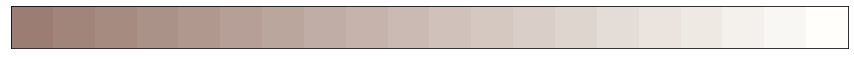

In [17]:
def rgb_hex(rgb):
    return '%02x%02x%02x' % rgb

def make_Ramp( ramp_colors ): 
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

bb = rgb_hex((156,126,116))
aa = rgb_hex((255,254,250))

ramp = make_Ramp(["#"+str(bb),"#"+str(aa)])

C:\Users\pauls\AppData\Local\Temp\ipykernel_4404\4122786488.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


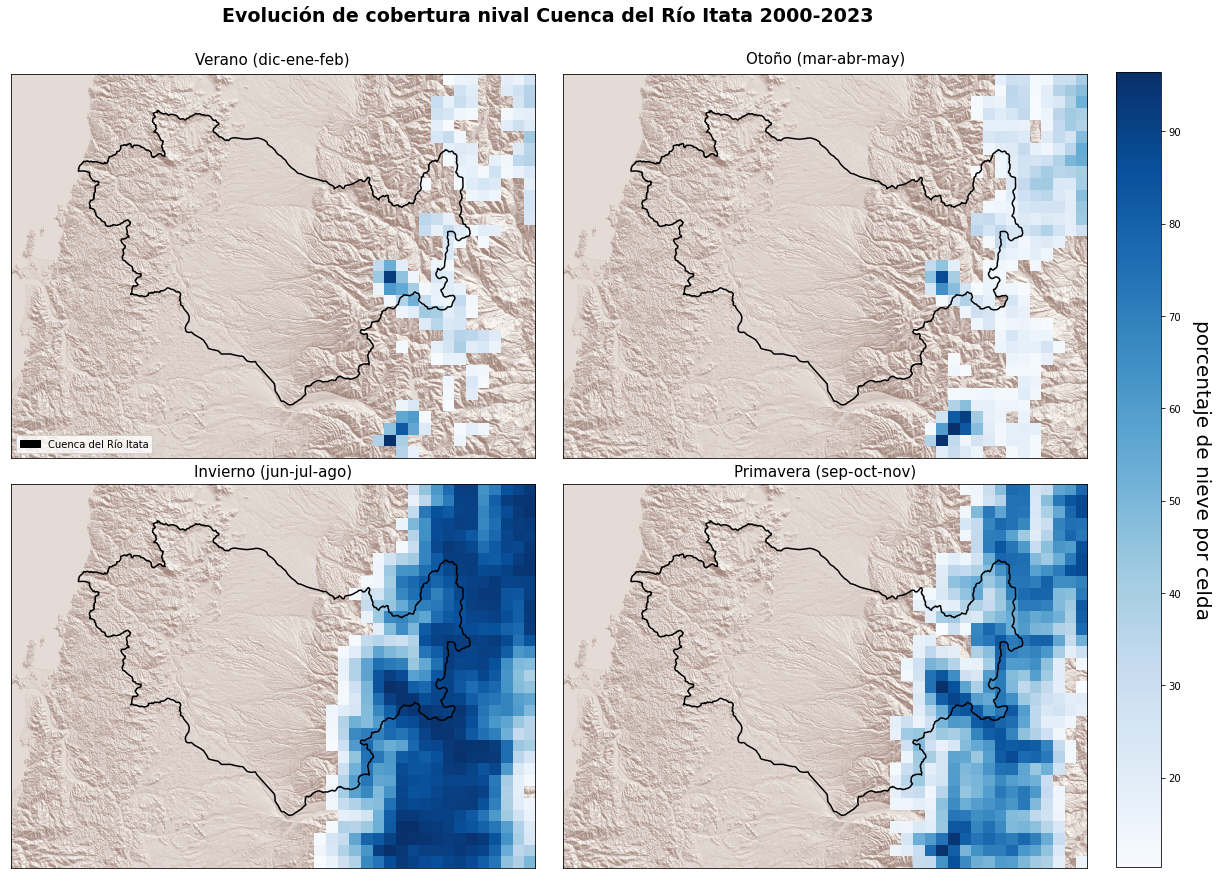

In [173]:
#Rasters

sc = glob.glob(r"P:\Projects\Itata\GIS\Snowcover\season\*.tif")
mask_tif = rio.open(r"P:\Projects\Itata\GIS\mask_itata.tif")
mask = mask_tif.read(1)
dem_path = r"P:\Projects\Itata\GIS\dem_itata.tif"
dem = rio.open(dem_path).read(1)

#Generate hillshade
hillshade = es.hillshade(dem)

#basins = gpd.read_file(r"P:\Projects\Itata\GIS\all_basins.shp")
basins = gpd.read_file(r"P:\Projects\Itata\Formato_inrhed\layers\Cuenca_Itata.shp")
stations = gpd.read_file(r"P:\Projects\Itata\GIS\stations_snow.shp")

#dem = rio.open(r"P:\Projects\Itata\GIS\dem_itata.tif").read(1)

summ = rio.open(sc[0]).read(1)
autum = rio.open(sc[1]).read(1)
wint = rio.open(sc[2]).read(1)
sprin = rio.open(sc[3]).read(1)

#Geometries

weap = gpd.read_file(r"P:\Projects\Itata\GIS\INRHED\Unidades_WEAP\unidades_WEAP_INRHED_simplificado.shp")

color = "Blues"

fig = plt.figure(figsize=(15.5,12))

############ 1

#Specific settings
ax0 = fig.add_subplot(221)
ax0.set_facecolor("lightgray")
ext0 = mask_tif.bounds
#plt.imshow(dem,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap="gray",alpha=0.7)
plt.imshow(hillshade,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=ramp)

#basins.plot(ax=ax0,facecolor="red",edgecolor="black",linewidth=1,column="Nombre",legend=True,alpha=0.5,legend_kwds={"loc": "lower left"})
basins.plot(ax=ax0,facecolor="None",edgecolor="black",linewidth=1.5,column="NOM_CUEN",legend=False,alpha=1,legend_kwds={"loc": "lower left"})
#glaciers.plot(ax=ax0,edgecolor="Black",facecolor="indigo",column="Name",legend=True)

red_patch = mpatches.Patch(color='black', label='Cuenca del Río Itata')
ax0.legend(handles=[red_patch],loc="lower left")

plt.imshow(summ,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=color)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
#plt.xticks(fontsize=8)
#plt.yticks(rotation=90,fontsize=8)
#plt.ticklabel_format(useOffset=False,style="plain")
plt.title("Verano (dic-ene-feb)",fontsize=15,pad=10)
#plt.grid(ls = "--",color="white")
#im_ratio = mask.shape[1]/mask.shape[0]
#plt.colorbar(fraction=0.0245*im_ratio).set_label("porcentaje de nieve por celda",rotation=270,labelpad=10,fontsize=10)
#plt.tight_layout()

#ax0.add_artist(ScaleBar(1,frameon=False,location='lower center',pad=0.9,box_alpha=0.7))

#x, y, arrow_length = 0.065, 0.96, 0.08
#ax0.annotate("N", xy=(x, y), xytext=(x, y-arrow_length),
#            arrowprops=dict(facecolor="black", width=2, headwidth=6),
#            ha="center", va="center", fontsize=13,
#            xycoords=ax0.transAxes)

#red.plot(ax=ax0,edgecolor="Blue",linewidth=0.5,alpha=0.7)



############ 2

#Specific settings
ax1 = fig.add_subplot(222)
ax1.set_facecolor("lightgray")
plt.imshow(hillshade,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=ramp)
plt.imshow(autum,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=color)

#plt.xticks(fontsize=8)
#plt.yticks(rotation=90,fontsize=8)
#plt.ticklabel_format(useOffset=False,style="plain")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

plt.title("Otoño (mar-abr-may)",fontsize=15,pad=10)
#plt.grid(ls = "--",color="white")
#im_ratio = mask.shape[1]/mask.shape[0]
#plt.colorbar(fraction=0.0245*im_ratio).set_label("porcentaje de nieve por celda",rotation=270,labelpad=10,fontsize=10)
#plt.tight_layout()



#basins.plot(ax=ax1,facecolor="red",edgecolor="black",linewidth=1,column="Nombre",legend=True,alpha=0.2,legend_kwds={"loc": "lower left"})
basins.plot(ax=ax1,facecolor="None",edgecolor="black",linewidth=1.5,column="NOM_CUEN",legend=False,alpha=1)

############ 3

#Specific settings
ax2 = fig.add_subplot(223)
ax2.set_facecolor("lightgray")
plt.imshow(hillshade,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=ramp)
plt.imshow(wint,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=color)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
#plt.xticks(fontsize=8)
#plt.yticks(rotation=90,fontsize=8)
#plt.ticklabel_format(useOffset=False,style="plain")
plt.title("Invierno (jun-jul-ago)",fontsize=15,pad=8)
#plt.grid(ls = "--",color="white")
#im_ratio = mask.shape[1]/mask.shape[0]
#plt.colorbar(fraction=0.0245*im_ratio).set_label("porcentaje de nieve por celda",rotation=270,labelpad=10,fontsize=10)
#plt.tight_layout()

#basins.plot(ax=ax2,facecolor="red",edgecolor="black",linewidth=1,column="Nombre",legend=True,alpha=0.2,legend_kwds={"loc": "lower left"})
basins.plot(ax=ax2,facecolor="None",edgecolor="black",linewidth=1.5,column="NOM_CUEN",legend=False,alpha=1)


############ 3

#Specific settings
ax3 = fig.add_subplot(224)
ax3.set_facecolor("lightgray")
plt.imshow(hillshade,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=ramp)
plt.imshow(sprin,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=color)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
#plt.xticks(fontsize=8)
#plt.yticks(rotation=90,fontsize=8)
#plt.ticklabel_format(useOffset=False,style="plain")
plt.title("Primavera (sep-oct-nov)",fontsize=15,pad=8)
#plt.grid(ls = "--",color="white")
#im_ratio = mask.shape[1]/mask.shape[0]
#plt.colorbar(fraction=0.0245*im_ratio).set_label("porcentaje de nieve por celda",rotation=270,labelpad=10,fontsize=10)
#basins.plot(ax=ax3,facecolor="red",edgecolor="black",linewidth=1,column="Nombre",legend=True,alpha=0.2,legend_kwds={"loc": "lower left"})
basins.plot(ax=ax3,facecolor="None",edgecolor="black",linewidth=1.5,column="NOM_CUEN",legend=False,alpha=1)
#stations.plot(ax=ax3,facecolor="red",edgecolor="black",linewidth=1,column="Nombre_1",legend=True,alpha=1,legend_kwds={"loc": "lower left"})

fig.set_facecolor("white")

#colorbar
cax = plt.axes([1.01, 0.014, 0.04, 0.92]) #([horizontal,vertical,width,height])
plt.colorbar(cax=cax).set_label("porcentaje de nieve por celda",rotation=270,labelpad=30,fontsize=20)


fig.suptitle("Evolución de cobertura nival Cuenca del Río Itata 2000-2023",fontweight="bold",fontsize=19,y=1.01)

fig.tight_layout()
#plt.subplots_adjust(top=0.97)
plt.show()


fig.savefig(r"P:\Projects\Itata\snowcover.png",bbox_inches="tight")

#### CÓDIGO BASE

In [91]:
dem_r = rio.open(dem_path)
dem = dem_r.read(1)
glaciers = gpd.read_file(glaciers_path)
basin = gpd.read_file(basin_path)
thickness = rio.open(thick_path).read(1)
red = gpd.read_file(red_path)

dem[dem == 0] = np.nan
thickness[thickness == 0] = np.nan

########################### INICIO

#Define subplots dimensions
fig = plt.figure(figsize=(15,15))

#Specific settings
ax0 = fig.add_subplot(121)
ax0.set_facecolor("lightgray")
ext0 = dem_r.bounds
plt.imshow(dem,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=custom_ramp)
plt.xticks(fontsize=8)
plt.yticks(rotation=90,fontsize=8)
plt.ticklabel_format(useOffset=False,style="plain")
plt.title("Cuenca del río Olivares",fontsize=20,pad=10,weight="bold")
plt.grid(ls = "--",color="white")
im_ratio = dem.shape[1]/dem.shape[0]
plt.colorbar(fraction=0.087*im_ratio).set_label("porcentaje de nieve por celda",rotation=270,labelpad=20,fontsize=10)
plt.tight_layout()

ax0.add_artist(ScaleBar(1,frameon=False,location='lower right',pad=1,box_alpha=0.7))

x, y, arrow_length = 0.065, 0.98, 0.06
ax0.annotate("N", xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor="black", width=4, headwidth=10),
            ha="center", va="center", fontsize=15,
            xycoords=ax0.transAxes)

red.plot(ax=ax0,edgecolor="Blue",linewidth=0.5,alpha=0.7)
basin.plot(ax=ax0,facecolor="None",edgecolor="black",linewidth=2.5,column="Name",legend=True)
glaciers.plot(ax=ax0,edgecolor="Black",facecolor="indigo",column="Name",legend=True)

#plt.legend(['hola','h','h','h'])

############################ FIN

ax1 = fig.add_subplot(122)
ax1.set_facecolor("lightgray")
ext0 = dem_r.bounds
plt.imshow(dem,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=custom_ramp,alpha=0.6)
plt.imshow(thickness,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap="Blues")
plt.xticks(fontsize=8)
plt.yticks(rotation=90,fontsize=8)
plt.ticklabel_format(useOffset=False,style="plain")
plt.title("Espesor glaciar",fontsize=20,pad=10,weight="bold")
plt.grid(ls = "--",color="white")
im_ratio = dem.shape[1]/dem.shape[0]
plt.colorbar(fraction=0.087*im_ratio).set_label("metros",rotation=270,labelpad=20,fontsize=10)
plt.tight_layout()

ax1.add_artist(ScaleBar(1,frameon=False,location='lower right',pad=1,box_alpha=0.5))

x, y, arrow_length = 0.065, 0.98, 0.06
ax1.annotate("N", xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor="black", width=4, headwidth=10),
            ha="center", va="center", fontsize=15,
            xycoords=ax1.transAxes)

red.plot(ax=ax1,edgecolor="Blue",linewidth=0.5,alpha=0.7)
basin.plot(ax=ax1,facecolor="None",edgecolor="black",linewidth=2.5,column="Name")
glaciers.plot(ax=ax1,edgecolor="Black",facecolor="None")

plt.show()

NameError: name 'dem_path' is not defined

#### Loop tries

In [ ]:
sc_mon = glob.glob(r"P:\Projects\Itata\GIS\Snowcover\mon\*.tif")
mask_tif = rio.open(r"P:\Projects\Itata\GIS\mask_itata.tif")
mask = mask_tif.read(1)

names = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]


# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))
#plt.subplots_adjust(hspace=0.5)
#plt.tight_layout()
fig.tight_layout()
fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through tickers and axes
for sc_mon, ax in zip(sc_mon, axs.ravel()):
    # filter df for ticker and plot on specified axes
    ext0 = mask_tif.bounds
    ax.imshow(rio.open(sc_mon).read(1),extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap="gist_earth")
    ax.set_facecolor("lightgray")
    plt.xticks(fontsize=8)
    plt.yticks(rotation=90,fontsize=8)
    plt.ticklabel_format(useOffset=False,style="plain")
    ax.set_title("Cuenca del río Olivares",fontsize=20,pad=10,weight="bold")

    # chart formatting
    #ax.set_title(ticker.upper())
    #ax.get_legend().remove()
    ax.set_xlabel("")
    fig.tight_layout()
    

plt.show()

In [ ]:
sc_mon[i]

C:\Users\pauls\Anaconda3\envs\gee\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


NameError: name 'custom_ramp' is not defined

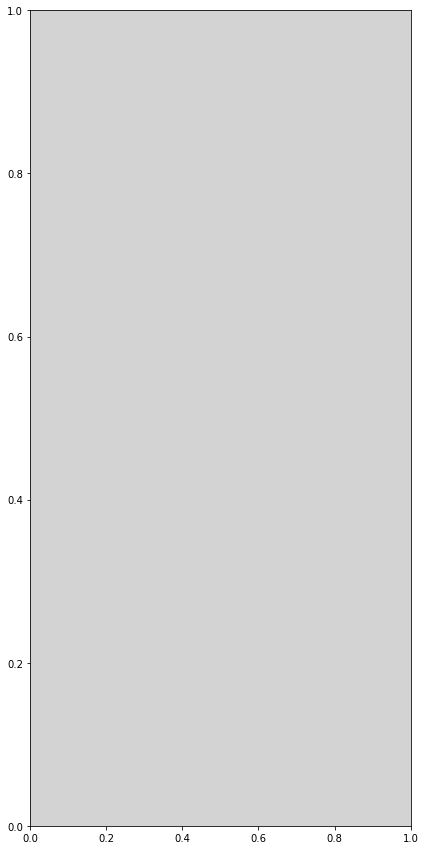

In [287]:
dem_path = r"P:\Projects\Olivares\GIS\dem_HR.tif"
glaciers_path = r"P:\Projects\Olivares\GIS\glaciers\selected_olivares.shp"
basin_path = r"P:\Projects\Olivares\GIS\catchment_HR.shp"
thick_path = r"P:\Projects\Olivares\GIS\glaciers\thickness_olivares.tif"
sent_path = r"P:\Projects\Olivares\GIS\sentinel\all_extent\Sentinel2_images\20230128T143721_20230128T145103_T19HCD.tif"
red_path = r"P:\Projects\Olivares\GIS\red.gpkg"

dem_r = rio.open(dem_path)
dem = dem_r.read(1)
glaciers = gpd.read_file(glaciers_path)
basin = gpd.read_file(basin_path)
thickness = rio.open(thick_path).read(1)
red = gpd.read_file(red_path)

dem[dem == 0] = np.nan
thickness[thickness == 0] = np.nan

########################### INICIO

#Define subplots dimensions
fig = plt.figure(figsize=(15,15))

#Specific settings
ax0 = fig.add_subplot(121)
ax0.set_facecolor("lightgray")
ext0 = dem_r.bounds
plt.imshow(dem,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=custom_ramp)
plt.xticks(fontsize=8)
plt.yticks(rotation=90,fontsize=8)
plt.ticklabel_format(useOffset=False,style="plain")
plt.title("Cuenca del río Olivares",fontsize=15,pad=10,weight="bold")
plt.grid(ls = "--",color="white")
im_ratio = dem.shape[1]/dem.shape[0]
plt.colorbar(fraction=0.087*im_ratio).set_label("porcentaje de nieve por celda",rotation=270,labelpad=20,fontsize=10)
plt.tight_layout()

ax0.add_artist(ScaleBar(1,frameon=False,location='lower right',pad=1,box_alpha=0.7))

x, y, arrow_length = 0.065, 0.98, 0.06
ax0.annotate("N", xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor="black", width=4, headwidth=10),
            ha="center", va="center", fontsize=15,
            xycoords=ax0.transAxes)

red.plot(ax=ax0,edgecolor="Blue",linewidth=0.5,alpha=0.7)
basin.plot(ax=ax0,facecolor="None",edgecolor="black",linewidth=2.5,column="Name",legend=True)
glaciers.plot(ax=ax0,edgecolor="Black",facecolor="indigo",column="Name",legend=True)

#plt.legend(['hola','h','h','h'])

############################ FIN

ax1 = fig.add_subplot(122)
ax1.set_facecolor("lightgray")
ext0 = dem_r.bounds
plt.imshow(dem,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap=custom_ramp,alpha=0.6)
plt.imshow(thickness,extent=[ext0[0],ext0[2],ext0[1],ext0[3]],cmap="Blues")
plt.xticks(fontsize=8)
plt.yticks(rotation=90,fontsize=8)
plt.ticklabel_format(useOffset=False,style="plain")
plt.title("Espesor glaciar",fontsize=20,pad=10,weight="bold")
plt.grid(ls = "--",color="white")
im_ratio = dem.shape[1]/dem.shape[0]
plt.colorbar(fraction=0.087*im_ratio).set_label("metros",rotation=270,labelpad=20,fontsize=10)
plt.tight_layout()

ax1.add_artist(ScaleBar(1,frameon=False,location='lower right',pad=1,box_alpha=0.5))

x, y, arrow_length = 0.065, 0.98, 0.06
ax1.annotate("N", xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor="black", width=4, headwidth=10),
            ha="center", va="center", fontsize=15,
            xycoords=ax1.transAxes)

red.plot(ax=ax1,edgecolor="Blue",linewidth=0.5,alpha=0.7)
basin.plot(ax=ax1,facecolor="None",edgecolor="black",linewidth=2.5,column="Name")
glaciers.plot(ax=ax1,edgecolor="Black",facecolor="None")

fig.suptitle("Sensitivity analysis Kling Gupta' efficiency",fontweight="bold",fontsize=20)
plt.show()